In [1]:
import sys
sys.path.append("../scripts/")
from GridMap import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import math
import random
import copy

In [2]:
class RRT():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.vertex = []
        self.candidate = []
        self.parent = []
        self.id_count = 0
        self.isStartFlag = True
        self.isFinishFlag = False
        self.isPathDraw = False
        self.ratePointGoal = 0.9
    
    def draw(self, ax, elems):
        if(not(self.isFinishFlag)):
            if(self.isStartFlag):
                x, y = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
                ax.plot(x, y, marker='.', color="blue")
                self.vertex.append([x, y])
                self.parent.append(0)
                self.isStartFlag = False

            if(random.random() > self.ratePointGoal):
                xp, yp = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
            else:
                xp = self.world.grid_num[0]*self.world.grid_step[0]*random.random()
                yp = self.world.grid_num[1]*self.world.grid_step[1]*random.random()
                xp, yp = self.goal([xp, yp])
            
            p = ax.plot(xp, yp, marker='.', color="red")
            elems += p
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n = self.getNeigborVertex([xp, yp], candidate)
                if(self.isGoal([xn, yn])):
                    break
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 1.1*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.remove([xp_n, yp_n])
                    if(candidate == []):
                        return
                else:
                    break
                    
            self.vertex.append([xn, yn])
            self.parent.append(self.vertex.index([xp_n, yp_n]))
            
            #頂点とエッジを描画
            ax.plot([xn, xp_n], [yn, yp_n], color="cyan", alpha=0.5)
            ax.plot(xn, yn, marker='.', color="blue", alpha=0.5)
            
            #ゴール判定
            if(self.isGoal([xn, yn])):
                self.isFinishFlag = True
        else:
            if(not(self.isPathDraw)):
                #経路の描画
                id = -1
                while(id != 0):
                    x1, y1 = self.vertex[id]
                    id = self.parent[id]
                    x2, y2 = self.vertex[id]
                    ax.plot([x1, x2], [y1, y2], color="red")
                self.isPathDraw = True
        
    def getNeigborVertex(self, xNew, candidate):
        distance = float('inf')
        xNear = []
        for x in candidate:
            if(distance > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2):
                distance = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                xNear = [x[0], x[1]]
        dx = xNew[0] - xNear[0]
        dy = xNew[1] - xNear[1]
        dr = dx**2 + dy**2
        x_init = xNear
        while(math.sqrt((x_init[0]-xNear[0])**2+(x_init[1]-xNear[1])**2) < math.sqrt((xNew[0]-xNear[0])**2+(xNew[1]-xNear[1])**2)):
            x_next = [x_init[0]+self.world.grid_step[0]*0.01*dx/dr, x_init[1]+self.world.grid_step[0]*0.01*dy/dr]
            if(self.isObstacle(x_next)):
                return xNear[0], xNear[1], xNear[0], xNear[1]
            if(math.sqrt((x_init[0]-xNear[0])**2+(x_init[1]-xNear[1])**2) > 2*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                return x_init[0], x_init[1], xNear[0], xNear[1]
            x_init = x_next
        return xNew[0], xNew[1], xNear[0], xNear[1]
    
    def isObstacle(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num > 29 or y_num > 29 or x_num < 0 or y_num < 0):
            return True
        if(self.grid_map[x_num][y_num] == '0'):
            return True
        else:
            return False

    def isGoal(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num > 29 or y_num > 29 or x_num < 0 or y_num < 0):
            return False
        if(self.grid_map[x_num][y_num] == '3'):
            return True
        else:
            return False
        
    def goal(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num > 29 or y_num > 29 or x_num < 0 or y_num < 0):
            return [0, 0]
        if(self.grid_map[x_num][y_num] == '3'):
            return [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        else:
            return x        

<IPython.core.display.Javascript object>


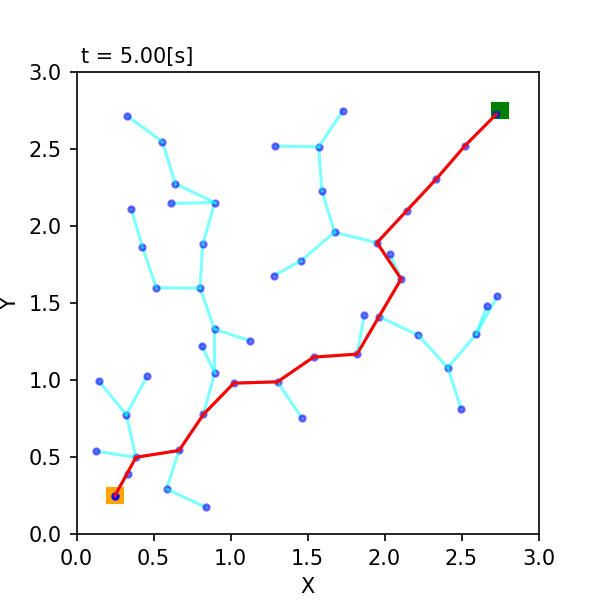

In [3]:
if __name__ == "__main__":
    time_span = 5
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRT(world))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #アニメーション保存